# Data loading

In [0]:
######## >>>>>>>>>>> For the google colab to be able to access the meta files you must add the APS360 team shared folder to your drive by right clicking on it <<<<<<<<<<< ##############
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
# Prints how many nulls there are in max and min temp
def test_null_csv_daily(station, start_year, end_year, out_name =  None):
    """
      Args:
          station (string): eg. "ON_6158355"
          start_year (int): Starting year
          end_year (int)  : Ending year
          start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
          out_name (optional string) : change the name of the output file
    """
    if out_name == None:
      out_name = station + '_' + str(start_year) + '-' + str(end_year)
    master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
    src_path = master_path + 'datasets/'
    newdf = pd.read_csv(src_path + out_name + ".csv")
    print("Max temp nulls: " + str(newdf['Max Temp (°C)'].isnull().sum()))
    print("Min temp nulls: " + str(newdf['Min Temp (°C)'].isnull().sum()))

In [0]:
import pandas as pd
# Interpolates null values in min and max temp cols
def inter_nulls_csv_daily(station, start_year, end_year, out_name =  None):
    """
      Args:
          station (string): eg. "ON_6158355"
          start_year (int): Starting year
          end_year (int)  : Ending year
          start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
          out_name (optional string) : change the name of the output file
    """
    if out_name == None:
      out_name = station + '_' + str(start_year) + '-' + str(end_year)
    master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
    src_path = master_path + 'datasets/'
    newdf = pd.read_csv(src_path + out_name + ".csv")
    newdf['Max Temp (°C)'] = newdf['Max Temp (°C)'].interpolate()
    newdf['Min Temp (°C)']= newdf['Min Temp (°C)'].interpolate()
    newdf.to_csv( src_path +  out_name + ".csv")

In [0]:
#Raw csv downloaded must be place in /raw folder
#Merged csv will be stored at /datasets folder
# Also interpolates the null max and min temp
def make_csv_daily(station, start_year, end_year, out_name =  None):
  """
    Args:
        station (string): eg. "ON_6158355"
        start_year (int): Starting year
        end_year (int)  : Ending year
        start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
        out_name (optional string) : change the name of the output file
    """
  if out_name == None:
    out_name = station + '_' + str(start_year) + '-' + str(end_year)
  master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
  src_path = master_path + 'raw/'
  dest_path = master_path + 'datasets/'
  fout = open(dest_path + out_name + ".csv","w+")
  in_base = "en_climate_daily_" + station + '_' #eg: 'en_climate_daily_ON_6158355_'
  in_end = '_P1D.csv'
  # first file:
  for line in open(src_path + in_base + str(start_year) + in_end):
      fout.write(line)
  # now the rest:    
  for num in range(start_year + 1, end_year + 1):
      f = open(src_path + in_base + str(num) + in_end)
      f.__next__() # skip the header
      for line in f:
          fout.write(line)
      f.close() # not really needed
  fout.close()
  inter_nulls_csv_daily(station, start_year, end_year, out_name)

In [0]:
####### run once #######
make_csv_daily("ON_6158355", 2007, 2016) # run once
make_csv_daily("ON_6158355", 2017, 2018) # run once
test_null_csv_daily("ON_6158355", 2007, 2016)
test_null_csv_daily("ON_6158355", 2017, 2018)

Max temp nulls: 0
Min temp nulls: 0
Max temp nulls: 0
Min temp nulls: 0


In [0]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
class WeatherDataset(Dataset):
    """Weather dataset."""

    def __init__(self, station, start_year, end_year, start_date = 0, end_date = None, num_days = 7, make_csv = False, out_name = None):
        """
        Args:
            station (string): eg. "ON_6158355"
            start_year (int): Starting year
            end_year (int)  : Ending year
            start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
            end_date (optional int) : end_date = 7 is day 8 of starting year(min = 7 because of LABEL!). If provided changes the end date from last day of last year.
            num_days (optional int) : num_days is the interval of days before the label.
            make_csv (optional bool): If true it will call make_csv_daily function to create the csv from /raw datasets into /datasets
            out_name (optional string) : change the name of the output file which it reads from
        """
        self.num_days = num_days
        if(out_name == None):
          self.out_name = station + '_' + str(start_year) + '-' + str(end_year)
        else:
          self.out_name = out_name
        master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
        dest_path = master_path + 'datasets/'
        if (make_csv):
          make_csv_daily(station, start_year, end_year, out_name =  out_name)

        self.cur_csv = pd.read_csv(dest_path + self.out_name +'.csv')

        self.start_date = start_date
        if( end_date == None):
          self.end_date = len(self.cur_csv) - start_date
        else:
          self.end_date = end_date

    def __len__(self):
        return self.end_date - self.start_date + 1 - self.num_days - 1

    def __getitem__(self, idx):
        data = self.cur_csv.loc[ idx + self.start_date : idx + self.start_date + self.num_days - 1 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
        data = np.asarray(data)
        data = data.astype('float')

        label = self.cur_csv.loc[ idx + self.start_date + self.num_days, ['Max Temp (°C)', 'Min Temp (°C)'] ]
        label = np.asarray(label)
        label = label.astype('float')

        data = data.flatten()

        #print('Data: {}'.format(data))
        #print('Data shape: {}'.format(data.shape))
        #print('Labels shape: {}'.format(label.shape))
        #print('Labels: {}'.format(label[:2]))
        sample = [data, label]

        return sample

In [0]:
start_year_train = 2007
end_year_train = 2016 #changed from 2019 because in our proposal we said 07-16 is train
start_date_train = 0
end_date_train = None
num_days_train = 7
station = "ON_6158355"
trainingSet = WeatherDataset(station, start_year_train, end_year_train, start_date_train, end_date_train, num_days=num_days_train, make_csv = False)

In [0]:
trainingSet[2]

[array([ 8.1,  2.4, 10.1,  4.8, 11.9,  7.7, 10. ,  4.1,  4.8,  3.3,  5.4,
         0.5,  2.5, -3.7]), array([-1.9, -5.7])]

In [0]:
start_year_val = 2017
end_year_val = 2018
start_date_val = 0
end_date_val = None
num_days_val = 7
# station stays the same
validationSet = WeatherDataset(station, start_year_val, end_year_val, start_date_val, end_date_val, num_days_val, make_csv = False)

In [0]:
import torch
train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=2, 
                                            num_workers=1, shuffle=True)
for i, data in enumerate(train_loader, 0):
  input, label = data
  print("input:")
  print(input)
  print("label:")
  print(label)

Streaming output truncated to the last 5000 lines.
       dtype=torch.float64)
label:
tensor([[ 4.0000, -7.0000],
        [14.4000,  9.1000]], dtype=torch.float64)
input:
tensor([[ -1.0000,  -9.3000,  -9.1000, -15.4000,  -4.6000, -15.8000,  -0.7000,
          -4.8000,  -1.5000, -11.1000,  -4.7000, -13.3000,  -5.3000, -10.3000],
        [ 10.6000,   3.0000,  14.8000,   8.7000,  14.0000,   4.8000,   9.8000,
           3.6000,   7.1000,   1.6000,  11.1000,   3.6000,  10.8000,   8.2000]],
       dtype=torch.float64)
label:
tensor([[-2.9000, -9.4000],
        [10.7000,  6.1000]], dtype=torch.float64)
input:
tensor([[ 14.7000,   5.2000,   5.4000,  -2.2000,   1.4000,  -3.2000,   3.4000,
          -1.4000,   2.0000, -10.3000,   1.9000, -10.4000,   8.3000,   1.9000],
        [  2.4000, -15.8000, -15.8000, -22.2000,  -7.7000, -16.2000,  -2.9000,
         -11.8000,   4.1000,  -4.0000,   7.3000,   2.9000,   3.4000,   1.3000]],
       dtype=torch.float64)
label:
tensor([[ 7.9000, -7.6000],
        

# RNN TRAINING

In [0]:
import os 
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import datasets, models, transforms 
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms 
use_cuda = True

#we prolly need cuda? to speed things up?

### Helper functions

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/gdrive/My Drive/APS360 Team/milestone 2/Checkpoints/weatherANNmodel_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
# not sure if this is needed

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [0]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Visualization of data

In [0]:
# laterrrrrrr

### Architecture

In [0]:
import logging
import datetime

import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib


In [0]:
class weatherRNN(nn.Module):

    def __init__(self, hidden_size = 10, input_size = 2, output_size = 2, n_layers = 1): #,dropout=DROPOUT
        super(weatherRNN, self).__init__()
        self.name = "weatherRNN"
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) # there is RNN, GRU, LSTM
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, inp,  hidden = None):
        if(hidden == None):
          out, _ = self.rnn(inp)
        else:
          out, _ = self.rnn(inp, hidden)
        out = self.decoder(out[:, -1, :])
        return out

In [0]:
# # hmmmm -> should seqlen be the number of inputs we put in? tbh a lil confused
# # input size will always be 14, output size will always be 2 
# # not sure what n_layers does but thats fine
# # dont think we utilize dropout either
# class weatherRNN(nn.Module):

#     def __init__(self, input_size = 14, hidden_size = 30, output_size = 2, n_layers = 1): #,dropout=DROPOUT
#         super(weatherRNN, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers

#         #self.encoder = nn.Embedding(input_size, hidden_size) # has nothing to do with "word embeddings" -> just indicate non linearity
#         # this is a drop out layer to prevent overfitting - we can get rid of it if we wanted to
#         #self.m = nn.Sequential(nn.ReLU(), nn.Dropout(p=0.2), nn.ReLU())
#         # encoder - converting back
#         self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) # there is RNN, GRU, LSTM
#         self.decoder = nn.Linear(hidden_size, output_size)

#     def forward(self, inp,  hidden=None):
#         # Look up the embedding
#         # inp = self.emb(inp)
#         # inp = self.encoder(inp)

#         # Set an initial hidden state and cell state
#         # h0 = num_layers * num_directions, batch, hidden_size
#         # NOT BI DIRECTIONAL: so num_directions = 1
#         # batch == size of the input
#         # hidden_size == predefined hidden size
#         print(inp.size())
#         print(self.n_layers)
#         print(len(inp))
#         print(self.hidden_size)
        
#         #h0 = torch.zeros((self.n_layers)*1, inp.size(0), self.hidden_size)
#         # h0 = torch.zeros((self.n_layers)*1, len(inp), self.hidden_size)
        
#         # print(h0.size())

#         # Forward propagate the rnn
#         out, _ = self.rnn(inp, hidden)
#         # Pass the output of the last time step to the classifier
#         output = self.decoder(output)
#         return out
#         # don't need the hidden state yet

### Training

In [0]:
import os 
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import datasets, models, transforms 
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms 

In [0]:
# Error defined as prediction being off more than 5°C
def compute_error(outputs, labels):
  err = 0.0
  number_items = 0
  for j, out in enumerate(outputs, 0):
      err += (abs(labels[j][0] - out[0]) > 5)
      err += (abs(labels[j][1] - out[1]) > 5)
      number_items += 2

  return err, number_items

In [0]:
# Error defined as mean difference of prediction and reallity
def compute_error(outputs, labels):
  err = 0.0
  number_items = 0
  for j, out in enumerate(outputs, 0):
      err += abs(labels[j][0] - out[0])
      err += abs(labels[j][1] - out[1])
      number_items += 2

  return err, number_items

In [0]:
def get_accuracy(net, loader, criterion):

    total_loss = 0.0
    total_err = 0.0
    number_items = 0

    for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs = inputs.view(inputs.shape[0], int(inputs.shape[1]/2), 2) #########
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
      #############################################
      outputs = net(inputs.float())
      loss = criterion(outputs, labels.float()) 
      total_loss += loss.item()
      
      cur_err, cur_num = compute_error(outputs, labels)
      total_err += cur_err
      number_items += cur_num
    err = float(total_err) / number_items
    loss = float(total_loss) / (i + 1)
    return err, loss

In [0]:
use_cuda = True
def train_rnn_network(net, trainingSet, validationSet, num_epochs, batch_size, learning_rate):
    criterion = nn.MSELoss() #criterion = nn.CrossEntropyLoss() We are doing regression not classification
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validationSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

     # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        number_items = 0
        for i, data in enumerate(train_loader, 0): # Itterate through each batch
            #print("Training", i, "out of", len(train_loader))
            # Get the inputs
            inputs, labels = data
            inputs = inputs.view(inputs.shape[0], int(inputs.shape[1]/2), 2) ########### batch_size, number of mini RNNs, input to each mini RNN

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            outputs = net(inputs.float())             # forward pass
            loss = criterion(outputs, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()

            cur_err, cur_num = compute_error(outputs, labels)
            total_train_err += cur_err
            number_items += cur_num
             

        train_err[epoch] = float(total_train_err) / number_items
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = get_accuracy(net, val_loader, criterion)
        
        print(("Epoch {}: Train err: {}, Train loss: {} |"
              + "Validation err: {}, Validation loss: {}"
                ).format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        #print(model_path) #for debugging the path smh
        #torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [0]:
weather_rnn = weatherRNN(hidden_size=10)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=40, learning_rate=0.004, num_epochs=45)

Training Started...
Epoch 1: Train err: 10.565822458156598, Train loss: 173.43346421614936 |Validation err: 9.203603341982777, Validation loss: 138.42288368626646
Epoch 2: Train err: 8.292866024714796, Train loss: 112.61832390660825 |Validation err: 7.510839763753643, Validation loss: 94.76374314960681
Epoch 3: Train err: 6.782585699764736, Train loss: 77.05108033055845 |Validation err: 6.208488131760728, Validation loss: 68.06394456562244
Epoch 4: Train err: 5.678963011516299, Train loss: 54.351784291474715 |Validation err: 5.31032731653414, Validation loss: 46.845725511249746
Epoch 5: Train err: 4.850625502605458, Train loss: 39.70856689370197 |Validation err: 4.577280796019367, Validation loss: 33.96857080961529
Epoch 6: Train err: 4.223751433624725, Train loss: 30.10147109238998 |Validation err: 4.015419841560145, Validation loss: 26.067018860264827
Epoch 7: Train err: 3.738049936467026, Train loss: 23.551917470019795 |Validation err: 3.6226304521286963, Validation loss: 21.2363658

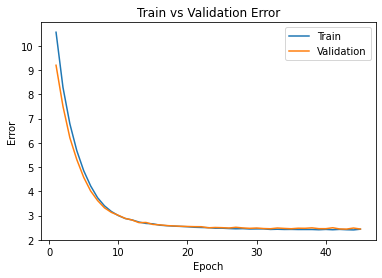

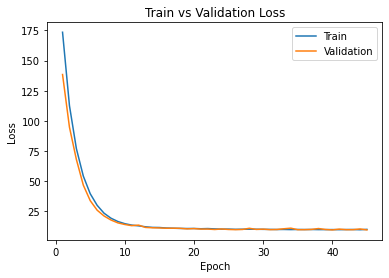

In [0]:
model_path = get_model_name("weatherRNN", batch_size=40, learning_rate=0.004, epoch=45)

plot_training_curve(model_path)


In [0]:
weather_rnn = weatherRNN(hidden_size=10)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.002, num_epochs=45)

Training Started...
Epoch 1: Train err: 10.771596886132487, Train loss: 178.10545330360287 |Validation err: 9.738159499409125, Validation loss: 148.85680572509764
Epoch 2: Train err: 9.077857154801901, Train loss: 132.244987581597 |Validation err: 8.403198283366645, Validation loss: 115.23415802001954
Epoch 3: Train err: 7.842953391781857, Train loss: 101.17680321365107 |Validation err: 7.348178398015589, Validation loss: 91.53627304077149
Epoch 4: Train err: 6.864189434598356, Train loss: 78.52755640373856 |Validation err: 6.481080801712857, Validation loss: 70.67967620849609
Epoch 5: Train err: 6.073102431349945, Train loss: 61.84879216991487 |Validation err: 5.770605785767566, Validation loss: 55.94275955200195
Epoch 6: Train err: 5.415275850809238, Train loss: 49.457139624923954 |Validation err: 5.188243495511151, Validation loss: 44.98489494323731
Epoch 7: Train err: 4.866677581486601, Train loss: 39.92591488947634 |Validation err: 4.659173428586354, Validation loss: 35.4592662239

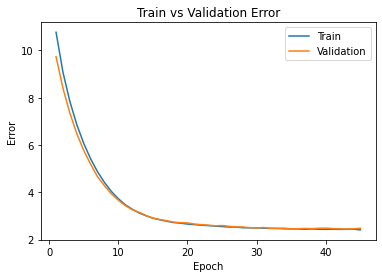

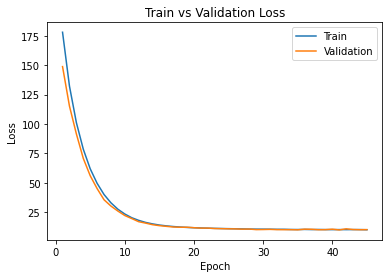

In [0]:
model_path = get_model_name("weatherRNN", batch_size=30, learning_rate=0.002, epoch=45)

plot_training_curve(model_path)


### Tuning

In [0]:
weather_rnn = weatherRNN(hidden_size=20)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.0001, num_epochs=40)

Training Started...
Epoch 1: Train err: 12.621230393921772, Train loss: 233.84865701394003 |Validation err: 12.321008706625777, Validation loss: 228.49370544433594
Epoch 2: Train err: 12.317096496601568, Train loss: 224.40606014064102 |Validation err: 11.992912295368987, Validation loss: 224.35908752441406
Epoch 3: Train err: 11.956084213081809, Train loss: 212.58286785688557 |Validation err: 11.6315644889498, Validation loss: 206.28106872558592
Epoch 4: Train err: 11.572250790276641, Train loss: 200.52317247234407 |Validation err: 11.260996061365118, Validation loss: 199.32449768066405
Epoch 5: Train err: 11.238808595299396, Train loss: 189.50173449907146 |Validation err: 10.983461115782422, Validation loss: 189.02835144042967
Epoch 6: Train err: 10.9894696862387, Train loss: 182.3958553877033 |Validation err: 10.764372698471675, Validation loss: 174.1953508758545
Epoch 7: Train err: 10.774152153740497, Train loss: 176.61333659437835 |Validation err: 10.56698230030114, Validation loss

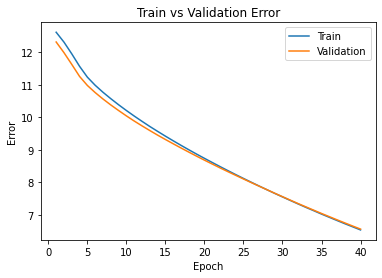

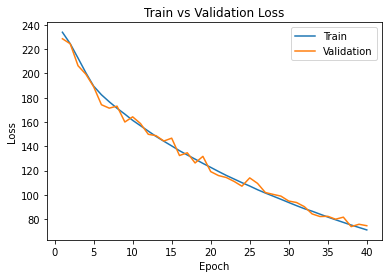

In [0]:
model_path = get_model_name("weatherRNN", batch_size=30, learning_rate=0.0001, epoch=40)

plot_training_curve(model_path)


In [0]:
weather_rnn = weatherRNN(hidden_size=25)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=40, learning_rate=0.0001, num_epochs=40)

Training Started...
Epoch 1: Train err: 12.305442094830036, Train loss: 223.20819672294286 |Validation err: 12.002246112978955, Validation loss: 220.8968794973273
Epoch 2: Train err: 11.983035717575772, Train loss: 213.3191602955694 |Validation err: 11.671530092599317, Validation loss: 215.20281500565378
Epoch 3: Train err: 11.63001923527051, Train loss: 202.1333465576172 |Validation err: 11.337770260792137, Validation loss: 198.144247356214
Epoch 4: Train err: 11.307121889202666, Train loss: 191.7890047819718 |Validation err: 11.050326461173892, Validation loss: 186.67385984721938
Epoch 5: Train err: 11.014993646404761, Train loss: 183.65308446469516 |Validation err: 10.753285805148673, Validation loss: 173.2311816968416
Epoch 6: Train err: 10.709775063390493, Train loss: 175.37551365727964 |Validation err: 10.50483137391655, Validation loss: 166.86974174097963
Epoch 7: Train err: 10.487041555140605, Train loss: 168.1243661797565 |Validation err: 10.312967209537877, Validation loss: 1

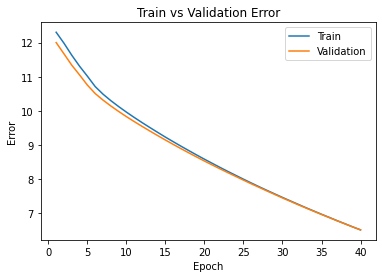

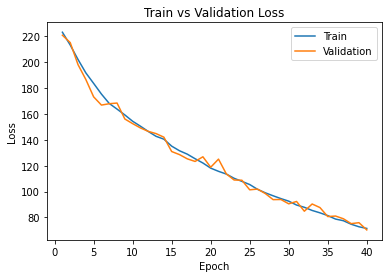

In [0]:
model_path = get_model_name("weatherRNN", batch_size=40, learning_rate=0.0001, epoch=40)

plot_training_curve(model_path)


In [0]:
weather_rnn = weatherRNN(hidden_size=10)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.00001, num_epochs=40)

Training Started...
Epoch 1: Train err: 12.84313996771659, Train loss: 244.00336456298828 |Validation err: 12.681625146200258, Validation loss: 250.3946960449219
Epoch 2: Train err: 12.822276109737283, Train loss: 243.1318263069528 |Validation err: 12.660973659281582, Validation loss: 245.84412536621093
Epoch 3: Train err: 12.801375846964808, Train loss: 242.12325180553998 |Validation err: 12.640089412774149, Validation loss: 241.65402893066405
Epoch 4: Train err: 12.780206497882306, Train loss: 241.26654165299212 |Validation err: 12.618908716730667, Validation loss: 238.8134295654297
Epoch 5: Train err: 12.75883051130106, Train loss: 240.9914364423908 |Validation err: 12.59755278869033, Validation loss: 241.70113647460937
Epoch 6: Train err: 12.737151765282855, Train loss: 240.23470368932504 |Validation err: 12.575854895122644, Validation loss: 235.24393768310546
Epoch 7: Train err: 12.71511613192482, Train loss: 239.7193757354236 |Validation err: 12.553858534078708, Validation loss: 

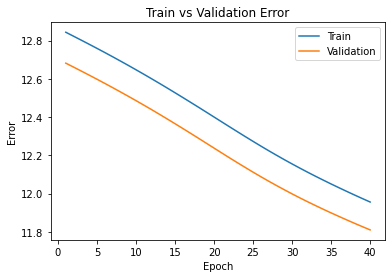

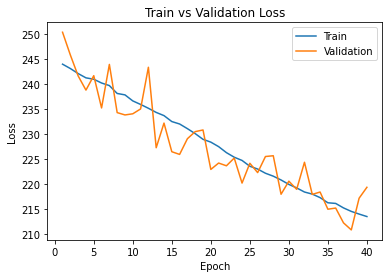

In [0]:
model_path = get_model_name("weatherRNN", batch_size=30, learning_rate=0.00001, epoch=40)

plot_training_curve(model_path)


In [0]:
weather_rnn = weatherRNN(hidden_size=10)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=25, learning_rate=0.006, num_epochs=40)

Training Started...
Epoch 1: Train err: 9.396107883712412, Train loss: 142.75508227413647 |Validation err: 7.210285365956617, Validation loss: 87.42395493079876
Epoch 2: Train err: 5.8796130021988064, Train loss: 59.06368215116736 |Validation err: 4.895723806838937, Validation loss: 40.99123882425243
Epoch 3: Train err: 4.182848606845929, Train loss: 29.794079558490075 |Validation err: 3.7989868729441, Validation loss: 23.167483428428913
Epoch 4: Train err: 3.3384405569792404, Train loss: 18.656849459426045 |Validation err: 3.116550557527635, Validation loss: 15.745145699073529
Epoch 5: Train err: 2.9561770371707197, Train loss: 14.376304476228478 |Validation err: 2.872501667175715, Validation loss: 13.252048278677053
Epoch 6: Train err: 2.786112187123534, Train loss: 12.789355803842414 |Validation err: 2.712626399926296, Validation loss: 12.05244546101011
Epoch 7: Train err: 2.695195256655602, Train loss: 11.956403663713639 |Validation err: 2.6333707945145672, Validation loss: 11.3549

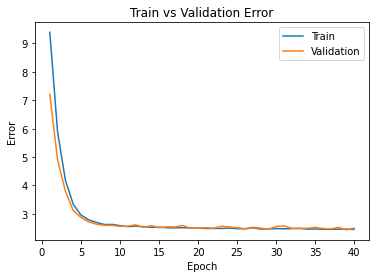

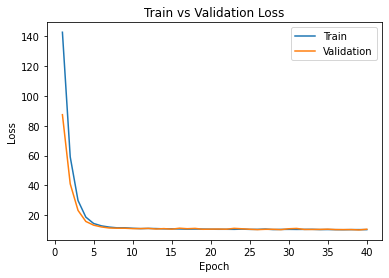

In [0]:
model_path = get_model_name("weatherRNN", batch_size=25, learning_rate=0.006, epoch=40)

plot_training_curve(model_path)


In [0]:
weather_rnn = weatherRNN(hidden_size=5)
if use_cuda:
  weather_rnn = weather_rnn.cuda()
train_rnn_network(weather_rnn, trainingSet=trainingSet, validationSet=validationSet, batch_size=30, learning_rate=0.0002, num_epochs=45)

Training Started...
Epoch 1: Train err: 12.384276035219198, Train loss: 225.3358034227715 |Validation err: 12.168988148019634, Validation loss: 221.07257385253905
Epoch 2: Train err: 12.24065109561359, Train loss: 221.0562421454758 |Validation err: 12.037936521306076, Validation loss: 216.96219512939453
Epoch 3: Train err: 12.102681059877886, Train loss: 216.455524256972 |Validation err: 11.89983512385752, Validation loss: 220.77790466308593
Epoch 4: Train err: 11.921280085156484, Train loss: 211.10821026661358 |Validation err: 11.671160431007854, Validation loss: 208.7751708984375
Epoch 5: Train err: 11.697689540070055, Train loss: 204.3495916147701 |Validation err: 11.49398254115253, Validation loss: 202.54460327148436
Epoch 6: Train err: 11.541162351091781, Train loss: 200.03221743224097 |Validation err: 11.365428599105169, Validation loss: 197.2383303833008
Epoch 7: Train err: 11.41154845413352, Train loss: 196.09083663440143 |Validation err: 11.246897341281219, Validation loss: 19

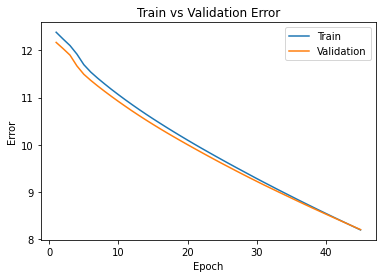

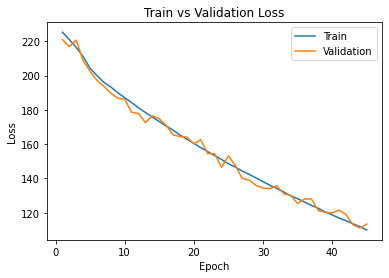

In [0]:
model_path = get_model_name("weatherRNN", batch_size=30, learning_rate=0.0002, epoch=45)

plot_training_curve(model_path)


best model???



In [0]:
class NEWweatherRNN(nn.Module):

    def __init__(self, hidden_size = 10, input_size = 2, output_size = 2, n_layers = 1): #,dropout=DROPOUT
        super(NEWweatherRNN, self).__init__()
        self.name = "NEWweatherRNN"
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) # there is RNN, GRU, LSTM
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, inp,  hidden = None):
        if(hidden == None):
          out, _ = self.rnn(inp)
        else:
          out, _ = self.rnn(inp, hidden)
        out = self.decoder(out[:, -1, :])
        return out

In [0]:
weather_rnn2 = NEWweatherRNN(hidden_size=10)
if use_cuda:
  weather_rnn2 = weather_rnn2.cuda()
train_rnn_network(weather_rnn2, trainingSet=trainingSet, validationSet=validationSet, batch_size=25, learning_rate=0.006, num_epochs=40)

In [0]:
model_path = get_model_name("NEWweatherRNN", batch_size=30, learning_rate=0.0002, epoch=45)

plot_training_curve(model_path)